## MTurk Candidate Generation for Images

We want to create an `Image_Candidate()` object, which contains 
* URL for the original image
* URL for the annotated image
* Array of BBox()

The `BBox()` objects include
* Top, Bottom, Right, Left coordinates 
* H,W,center, area, perimeter, corner helper functions

A function `extract_box()` that takes in a `Image_Candidate()` and an index for the box (__NEED A -1 SOMEWHERE__) and returns a `BBox()` object. 

A function `top_edge(box)` that returns an integer for top of the `box`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import os
import sys
sys.path.append('/dfs/scratch0/paroma/coco')
sys.path.append('/dfs/scratch0/paroma/coco/PythonAPI/')

from pycocotools.coco import COCO
import skimage.io as io
import pylab
import cv2

## Load Visual Genome Data
Load the train and validation sets for this task (pre-processed earlier). Split into train and validation based on splits from MS-COCO.

In [2]:
vg_folder = '/dfs/scratch0/paroma/visual_genome/'
train_mscoco = np.load(vg_folder+'train_mscoco.npy')
val_mscoco = np.load(vg_folder+'val_mscoco.npy')

train_ground = np.load(vg_folder+'train_ground.npy')
val_ground = np.load(vg_folder+'val_ground.npy')

In [3]:
#sizes of train-val-test
print "Train Set Size: ", np.shape(train_mscoco)[0], " Positive: ", np.shape(np.where(train_ground == 1))[1] 
print "Val Set Size: ", np.shape(val_mscoco)[0], " Positive: ", np.shape(np.where(val_ground == 1))[1] 

Train Set Size:  903  Positive:  270
Val Set Size:  429  Positive:  86


## Load MS-COCO Data
Load the annotations for train and validation from MS-COCO database.

In [4]:
def generate_anns(filename, coco_ids):
    coco=COCO(filename)
    catIds = coco.getCatIds(catNms=['person','bicycle']);
    set_anns = []

    for set_id in coco_ids:
        annIds = coco.getAnnIds(imgIds=set_id, catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)

        temp_list = []
        for i in xrange(len(anns)):
            temp_dict = {'category_id':anns[i]['category_id'], 'bbox':anns[i]['bbox']}
            temp_list.append(temp_dict)
        set_anns.append(temp_list)
        
    return set_anns

In [5]:
from pycocotools.coco import COCO
coco_path = '/dfs/scratch0/paroma/coco/annotations/'

train_anns = generate_anns(coco_path+'instances_train2014.json', train_mscoco)
#val_anns = generate_anns(coco_path+'instances_val2014.json', val_mscoco)

loading annotations into memory...
Done (t=20.38s)
creating index...
index created!


In [20]:
np.save('/dfs/scratch0/paroma/coco/annotations/train_anns.npy', np.array(train_anns))
train_anns = np.load('/dfs/scratch0/paroma/coco/annotations/train_anns.npy')
train_anns = train_anns.tolist()

## Image_Candidate Class
We want to create an `Image_Candidate()` object, which contains 
* URL for the original image
* URL for the annotated image
* Array of BBox()

In [21]:
class Image_Candidate(object):
    
    def __init__(self, idx=-1,coco_ids=train_mscoco,coco_anns=train_anns):
        if idx <= -1 or idx >= 903 :
            print 'Invalid Train Image Index'
        
        self.idx = idx
        self.coco_ann = coco_anns[idx] #CURRENT IMAGE ANNOTATIONS
        self.original_url = 'http://mscoco.org/images/'+ str(coco_ids[idx])
        self.annotated_url = 'http://paroma.github.io/turk_images/train_' + str(idx)
        
        def generate_boxes(self):
            bboxes = []
            for i in xrange(len(self.coco_ann)):
                bbox_ann = self.coco_ann[i]
                bbox_curr = BBox(bbox_ann,coco_ids[idx])
                bboxes.append(bbox_curr)
            return bboxes
        self.bboxes = generate_boxes(self)

### BBox Class
The `BBox()` objects include
* Top, Bottom, Right, Left coordinates 
* H,W,center, area, perimeter, corner helper functions
* Index of parent image (image number from original MS-COCO dataset)

In [22]:
class BBox(object):
    
    def __init__(self, attr_dict, idx):
        self.parent_idx = idx
        
        x,y,w,h = attr_dict['bbox']
        label = attr_dict['category_id']
        
        self.width = w
        self.height = h
        
        self.top = y
        self.left = x
        self.bottom = self.top+h
        self.right = self.left+w
        
        def area(self):
            return self.width*self.height
        
        def perimeter(self):
            return 2*(self.width+self.height)
        
        def top_edge(self):
            return self.top
            
        def bottom_edge(self):
            pass
        
        def left_edge(self):
            pass
        
        def right_edge(self):
            pass
        
        def bottom_edge(self):
            pass
        

### Extract Box Function
A function `extract_box()` that takes in a `Image_Candidate()` and an index for the box (__NEED A -1 SOMEWHERE__) and returns a `BBox()` object. 

_ABOVE is actually <= for the numerical top vs bottom_

In [23]:
def extract_box(image,idx):
    return image.bboxes[idx]

def extract_edge(bbox,side):
    return getattr(test_box, side)

def is_below(b1,b2):
    return b1 > b2

### Sample Top_Edge Function
A function `top_edge(box)` that returns an integer for top of the `box`

In [24]:
def top_edge(box):
    return box.top

Top Edge Numerically is:  71.67


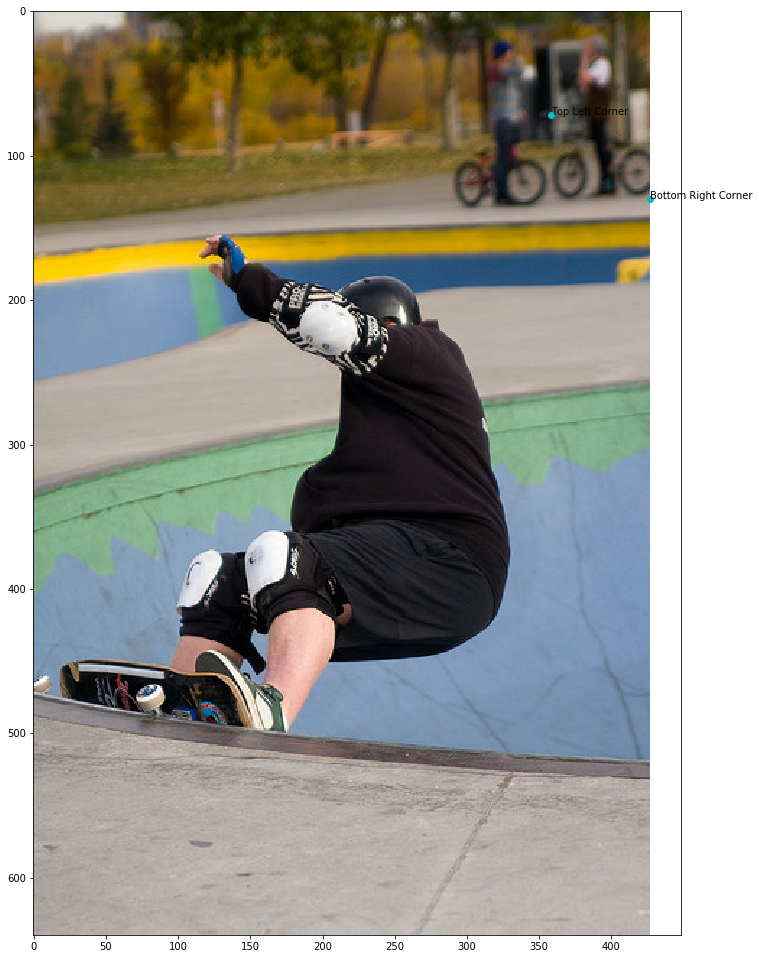

In [25]:
plt.figure(figsize=(480/36,640/36))

test_image = Image_Candidate(idx=11)
test_box = extract_box(test_image,0)

print 'Top Edge Numerically is: ', test_box.top

plt.imshow(io.imread(test_image.original_url))
plt.plot(test_box.left, test_box.top, 'co')
plt.text(test_box.left, test_box.top, 'Top Left Corner')
plt.plot(test_box.right, test_box.bottom, 'co')
plt.text(test_box.right, test_box.bottom, 'Bottom Right Corner')

In [32]:
test_image.bboxes[3-1].bottom

138.85

In [33]:
test_image.bboxes[5-1].bottom

135.51

In [36]:
is_below(test_image.bboxes[3-1].bottom, test_image.bboxes[5-1].bottom)

True

In [38]:
train_anns[0]

[{'bbox': [390.48, 384.93, 133.16, 94.73], 'category_id': 2},
 {'bbox': [247.89, 394.97, 147.34, 85.03], 'category_id': 2},
 {'bbox': [44.12, 398.04, 218.42, 81.96], 'category_id': 2},
 {'bbox': [543.06, 394.59, 96.94, 85.41], 'category_id': 2},
 {'bbox': [409.17, 320.53, 132.19, 22.34], 'category_id': 2},
 {'bbox': [306.58, 318.88, 7.88, 21.33], 'category_id': 2},
 {'bbox': [300.76, 301.79, 2.88, 11.57], 'category_id': 1},
 {'bbox': [379.29, 293.43, 16.99, 52.72], 'category_id': 1},
 {'bbox': [367.67, 297.31, 13.49, 48.23], 'category_id': 1},
 {'bbox': [276.82, 290.66, 24.19, 59.19], 'category_id': 1},
 {'bbox': [396.56, 287.48, 16.84, 69.39], 'category_id': 1},
 {'bbox': [393.25, 292.24, 7.92, 33.36], 'category_id': 1},
 {'bbox': [416.74, 292.73, 8.23, 20.36], 'category_id': 1},
 {'bbox': [307.95, 291.23, 15.41, 49.02], 'category_id': 1},
 {'bbox': [530.25, 286.79, 9.08, 52.35], 'category_id': 1},
 {'bbox': [573.52, 291.64, 6.32, 32.29], 'category_id': 1},
 {'bbox': [189.01, 301.16, 